In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv('AmesHousing.tsv', delimiter='\t')

In [3]:
data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [4]:
def transform_features(df):
    
    # remove features with more than 5% missing values
    missing_value_counts = df.isnull().sum()
    df = df[missing_value_counts[missing_value_counts/len(df)<=0.05].index]
    
    # fill in the missing values using mean of each column
    df = df.fillna(df.mean())
    
    # create new features
    df['Years Until Remod'] = df['Year Remod/Add'] - df['Year Built']
    df['Years Built'] = df['Yr Sold'] - df['Year Built']
    df = df.drop(['Year Remod/Add', 'Yr Sold', 'Year Built'], axis=1)
    
    # drop features aren't useful for machine learning
    df = df.drop(['Order', 'PID'], axis=1)
    
    # drop features that leak infomation about the sale
    df = df.drop(['Mo Sold', 'Sale Type', 'Sale Condition'], axis=1)
    
    return df

In [5]:
data_tf = transform_features(data)
data_tf.head()

,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,Years Until Remod,Years Built
0,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,...,210,62,0,0,0,0,0,215000,0,50
1,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,140,0,0,0,120,0,0,105000,0,49
2,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,...,393,36,0,0,0,0,12500,172000,0,52
3,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,...,0,0,0,0,0,0,0,244000,0,42
4,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,...,212,34,0,0,0,0,0,189900,1,13


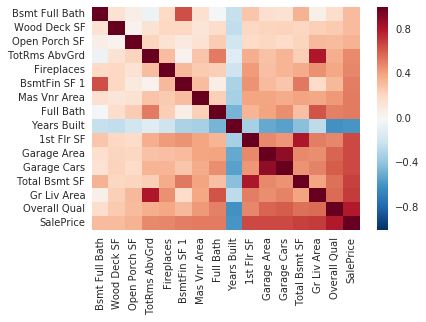

In [6]:
# generate a correlation heatmap matrix of the numerical features in the training set
train_num = data_tf[:1460].select_dtypes(include=['integer', 'float'])
sorted_corrs = train_num.corr()['SalePrice'].abs().sort_values()
strong_corrs = sorted_corrs[sorted_corrs>0.3].index
sns.heatmap(train_num[strong_corrs].corr())

### Which features are colinear with othrer columns?
* 1st Flr SF
* Garage Cars
* TotRms AbvGrd
* Bsmt Full Bath

In [7]:
# show the non-numerical columns has more than 10 unique values
train_cat = data_tf[:1460].select_dtypes(exclude=['integer', 'float'])
train_cat.nunique()[train_cat.nunique()>10]

Neighborhood    26
Exterior 1st    14
Exterior 2nd    16
dtype: int64

In [8]:
# show  a few unique values 
# but more than 95% of the values in the column belong to a specific category
for column in train_cat:
    value_count = train_cat[column].value_counts()
    value_percentage = value_count / value_count.sum()
    if len(value_percentage[value_percentage>0.95]):
        print('---- {} ----'.format(column))
        print(value_percentage)
        print('\n')

---- Street ----
Pave    0.996575
Grvl    0.003425
Name: Street, dtype: float64


---- Utilities ----
AllPub    0.997945
NoSewr    0.001370
NoSeWa    0.000685
Name: Utilities, dtype: float64


---- Land Slope ----
Gtl    0.956849
Mod    0.037671
Sev    0.005479
Name: Land Slope, dtype: float64


---- Condition 2 ----
Norm      0.987671
Feedr     0.005479
PosN      0.002055
Artery    0.002055
RRNn      0.001370
PosA      0.001370
Name: Condition 2, dtype: float64


---- Roof Matl ----
CompShg    0.985616
Tar&Grv    0.009589
WdShake    0.002740
WdShngl    0.001370
Membran    0.000685
Name: Roof Matl, dtype: float64


---- Heating ----
GasA     0.982877
GasW     0.008904
Grav     0.004110
Wall     0.002055
OthW     0.001370
Floor    0.000685
Name: Heating, dtype: float64




In [22]:
def select_features(df):
    # select features correlate strongly with the target column
    df_num = df.select_dtypes(include=['integer', 'float'])
    corrs = df_num.corr()['SalePrice'].abs()
    strong_corrs = sorted_corrs[sorted_corrs>0.3].index
    df_num = df_num[strong_corrs]
    
    # remove non-numerical columns has more than 10 unique values
    df_cat = df.select_dtypes(exclude=['integer', 'float'])
    df_cat = df_cat.loc[:, df_cat.nunique()<=10]
    
    # remove the columns have a few unique values 
    # but more than 95% of the values in the column belong to a specific category
    for column in df_cat:
        value_count = df_cat[column].value_counts()
        value_percentage = value_count / value_count.sum()
        if len(value_percentage[value_percentage>0.95]):
            df_cat = df_cat.drop(column, axis=1)
            
    # create dummy columns and add back to the dataframe
    cat_cols = df_cat.columns
    df_cat = pd.get_dummies(df_cat)
            
    # merge the numerical and categorical columns
    df_fs = pd.concat([df_cat, df_num], axis=1)
    
    return df_fs

In [23]:
data_fs = select_features(data_tf)

In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

def train_num_and_test(df, k=0):
    
    features = df.columns.drop('SalePrice')
    target = 'SalePrice'
    lr = LinearRegression()
    
    # holdout validation
    if k == 0:
        train = df[:1460]
        test = df[1460:]
        lr.fit(train[features], train[target])
        pred_test = lr.predict(test[features])
        rmse = np.sqrt(mean_squared_error(pred_test, test[target]))
        
    # simple cross validation
    elif k == 1:
        fold_one = df[:1460]
        fold_two = df[1460:]
        
        # train on fold 1 and test on fold 2
        lr.fit(fold_one[features], fold_one[target])
        pred_two = lr.predict(fold_two[features])
        rmse_two = np.sqrt(mean_squared_error(pred_two, fold_two[target]))
        
        # train on fold2 and test on fold 1
        lr.fit(fold_two[features], fold_two[target])
        pred_one = lr.predict(fold_one[features])
        rmse_one = np.sqrt(mean_squared_error(pred_one, fold_one[target]))
        
        rmse = np.mean([rmse_two, rmse_one])
        
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmses = []
        for train_idx, test_idx in kf.split(df):
            train = df.iloc[train_idx]
            test = df.iloc[test_idx]
            X_train, y_train = train[features], train[target]
            X_test, y_test = test[features], test[target]
            
            lr.fit(X_train, y_train)
            y_pred = lr.predict(X_test)
            rmses.append(np.sqrt(mean_squared_error(y_test, y_pred)))
            
        rmse = np.mean(rmses)        
    
    return rmse

In [37]:
train_num_and_test(data_fs, k=5)

30220.34314542861